### Housing Violations Dataset Exploration


Now that we have all of our data, we want to start finding trends and visualizing the data. We come into this asking some very elementary questions. At this point we just want to catergorize our data. We are going to want to see which boros have the most incidents and how long they take to respond to see if there are any problems in some boros but to do so we need to see the shape of our data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [3]:
df = pd.read_csv('../data/clean.csv', parse_dates = ['inspectiondate',
                                                     'currentstatusdate']).drop('newcorrectbydate',axis=1)

In [4]:
df.count()

violationid              49377
buildingid               49377
boro                     49377
zip                      49375
inspectiondate           49377
originalcorrectbydate    48724
novdescription           49377
class                    49377
currentstatus            49377
currentstatusdate        49377
currentstatusdate        49377
dtype: int64

So we see we have a lot of rows to work with. Now on a most basic level we want to see what the status of these violations are

In [5]:
statusCounts = df.currentstatus.value_counts()
statusCounts

VIOLATION CLOSED                            41426
VIOLATION DISMISSED                          4113
FIRST NO ACCESS TO RE- INSPECT VIOLATION     1428
NOT COMPLIED WITH                            1274
NOV SENT OUT                                  559
DEFECT LETTER ISSUED                          175
NOV CERTIFIED LATE                            171
SECOND NO ACCESS TO RE-INSPECT VIOLATION      139
VIOLATION WILL BE REINSPECTED                  23
INVALID CERTIFICATION                          22
INFO NOV SENT OUT                              21
FALSE CERTIFICATION                            19
NOTICE OF ISSUANCE SENT TO TENANT               3
CIV14 MAILED                                    3
VIOLATION REOPEN                                1
Name: currentstatus, dtype: int64

Interestingly enough, most of the cases are closed. Now what can cause a violation to be closed? According to the dataset description... `The violation status is closed when the violation is observed/verified as corrected by HPD or as certified by the landlord.`

This leads to a noteworthy first observation: *Most violations are in fact corrected for*

Now of the ones that aren't... some have been dissmissed, meaning taken away with. Some were not complied with, and others are still in the early stages of processing. Let's normalize these numbers by turning them into percents so that they are easier to look at. 

In [6]:
total = df.currentstatus.value_counts().sum()
statusCounts/total * 100

VIOLATION CLOSED                            83.897361
VIOLATION DISMISSED                          8.329789
FIRST NO ACCESS TO RE- INSPECT VIOLATION     2.892035
NOT COMPLIED WITH                            2.580149
NOV SENT OUT                                 1.132106
DEFECT LETTER ISSUED                         0.354416
NOV CERTIFIED LATE                           0.346315
SECOND NO ACCESS TO RE-INSPECT VIOLATION     0.281508
VIOLATION WILL BE REINSPECTED                0.046580
INVALID CERTIFICATION                        0.044555
INFO NOV SENT OUT                            0.042530
FALSE CERTIFICATION                          0.038479
NOTICE OF ISSUANCE SENT TO TENANT            0.006076
CIV14 MAILED                                 0.006076
VIOLATION REOPEN                             0.002025
Name: currentstatus, dtype: float64

Viewing the numbers like this makes it really clear that most cases were closed, a whopping 80 percent.

Now this begs the obvious question: Why?
Here are a couple of possibilities...
1. Records tend to only be entered into the system when they are closed. 
2. We are looking at data from a very narrow time span.

Now 1 would be a data entry problem. 2 though we could really easily verify. Let's graph number of incidents per month...
This is going to be scary though since we need to sort the data to construct a line plot. 

In [7]:
df['monthCurrentStatus'] = df.currentstatusdate.dt.to_period('M') #First we extract the months/year
sorted_df = df.sort_values('monthCurrentStatus') # beware.... this is slow....That's why I got rid of days. 

In [8]:
counts = sorted_df.groupby('monthCurrentStatus').count().sum(axis=1) #Yes we could use value_counts but then we have to resort
counts.head()

monthCurrentStatus
2008-06    286
2008-07     11
2008-08     11
2008-09     44
2008-10     22
Freq: M, dtype: int64

Text(0.5, 1.0, 'Number of Incidents Statuses over Time')

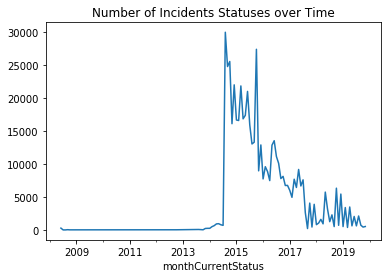

In [9]:
counts.plot()
plt.title("Number of Incidents Statuses over Time")

Now we immediatly see that a lot our incidents were torwards the end of 2014 and less were reported since then. 
This doesn't iteself answer our original question of why are almost all the statuses closed but it seems like most of the data was entered during this period when the data was marked as completed.

Now this is really odd... This is why. Remember how at the botumn of the previous <a href = https://github.com/harisx91/NYCHousingMaintenanceCodeProject/blob/master/notebooks/HousingCleaning.ipynb> notebook </a> I said that the Socrata API was not giving us a random sample? We can prove it here...

We have a count of how many incidents occured in 2016, 2017, and 2018 from the previous notebook Let's eyeglance (not using statistics) if the numbers match these. 

In [20]:
df_2016 = pd.read_csv('../data/inspection_2016.csv', parse_dates = ['inspectiondate'])
df_2017 = pd.read_csv('../data/inspection_2017.csv', parse_dates = ['inspectiondate'])
df_2018 = pd.read_csv('../data/inspection_2018.csv', parse_dates = ['inspectiondate'])
df_2014 = pd.read_csv('../data/inspection_2014.csv', parse_dates = ['inspectiondate'])

In [21]:
print('There are {:d} records in 2016 '.format(len(df_2016)))
print('There are {:d} records in 2017 '.format(len(df_2017)))
print('There are {:d} records in 2018 '.format(len(df_2018)))
print('There are {:d} records in 2014 '.format(len(df_2014)))

There are 513534 records in 2016 
There are 556883 records in 2017 
There are 642849 records in 2018 
There are 299592 records in 2014 


And by inspection on the graph... we can clearly see that this ratio does not hold. 2018 should have the most. Instead we have the increase in 2014. This is why in order to answer the question about what season incidents occur in we can't actually use this data. Lucky us, someone thought ahead and created all the data we need to evaluate this.

#### What season do most incidents occur in

So now we contextualized our data a bit more... We know when the data was from and we know the what: that most of the rows show that the incidents were resolved. Let's now focus more on the what of how severe the incidents were and on the where. Where do most incidents take place? Also which areas are there the most severe incidents?

Text(0.5, 1.0, 'Incidents per boro')

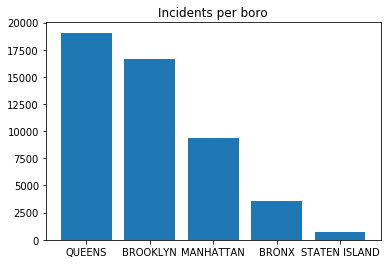

In [15]:
plt.bar(df['boro'].unique(), df['boro'].value_counts())
plt.title("Incidents per boro")

Queens has the most number of incidents with Manhattan, the Bronx, and Staten Island significantly less.
It's not just that there are more incidents though. The ratio of incidents between Queens and Brooklyn and the other boros is significantly more. We should investigate why this is? Is there something problematic about these buildings like are they older?

It's also important though to see how severe these incidents are...

In [16]:
df['class'].value_counts()

B    30404
C     9325
A     9086
I      556
Name: class, dtype: int64

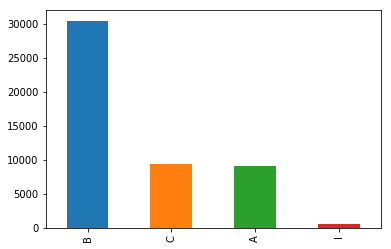

In [17]:
class_counts = df['class'].value_counts()
class_counts.plot.bar()

As we can see class B(which is medium severe) has the highest number. C is high severity and is about equal with A (low severity). I incidents aren't really violations but simply notifications. Now let's see if there are overly many severe incidents in any boros

In [19]:
df.groupby(['boro','class']).size()

boro           class
BRONX          A         3188
               B        10520
               C         2826
               I          106
BROOKLYN       A         3477
               B        11606
               C         3739
               I          238
MANHATTAN      A         1716
               B         5710
               C         1820
               I           90
QUEENS         A          601
               B         2069
               C          802
               I          116
STATEN ISLAND  A          104
               B          499
               C          138
               I            6
dtype: int64

Since Brooklyn has the highest number of incident, it makes sense that largest class incident happens there. 

It is easier to read if sorted

In [20]:
df.groupby(['boro','class']).size().sort_values(ascending=False)

boro           class
BROOKLYN       B        11606
BRONX          B        10520
MANHATTAN      B         5710
BROOKLYN       C         3739
               A         3477
BRONX          A         3188
               C         2826
QUEENS         B         2069
MANHATTAN      C         1820
               A         1716
QUEENS         C          802
               A          601
STATEN ISLAND  B          499
BROOKLYN       I          238
STATEN ISLAND  C          138
QUEENS         I          116
BRONX          I          106
STATEN ISLAND  A          104
MANHATTAN      I           90
STATEN ISLAND  I            6
dtype: int64

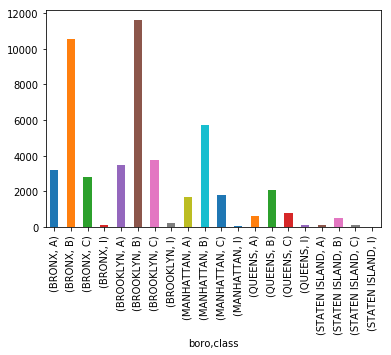

In [21]:
df.groupby(['boro','class']).size().plot.bar()

We don't see any boro which violates this ratio of having more class B incidents. Because of this we don't feel a need to propose any immediate action 

Now let's try to see if there is anything problematic about how long each boro takes to respond to incidents

In [22]:
inspection_date = df['inspectiondate']
current_status_date = df['currentstatusdate']

In [23]:
df['days_between'] = pd.to_timedelta(current_status_date - inspection_date, unit='d').dt.days
closed_issues = df[df['currentstatus'] == 'VIOLATION CLOSED']

In [24]:
daysOpenDf = closed_issues[['days_between', 'boro']]
daysOpenDf.head()

,days_between,boro
0,8066,QUEENS
1,7568,QUEENS
2,7568,QUEENS
3,7566,QUEENS
4,11005,BROOKLYN


In [25]:
daysOpenSeries = daysOpenDf.groupby('boro').median() #median to ignore outliers 

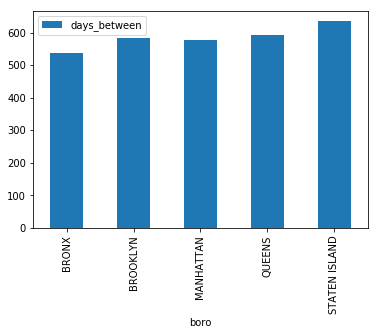

In [26]:
daysOpenSeries.plot.bar()

Staten Island seems to take the longest to repond to incidents. They also have the fewest number of incidents so this difference might not be significant. It's a pretty noteworthy observation that these numbers don't differ so much.
Although we found that certain boros have more incidents, the way they are dealt with is consistant and reasonable. All that should be addressed is why Queens and Brooklyn have so many more incidents.  